# E9 222 Signal Processing in Practice

**Name** - Saptarshi Mandal

**S.R. No.** - 22925

**Department** - Electrical Engineering

**Stream** - Signal Processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Q1**

A benchmark system, IEEE 33bus - 12.66KV, is used to generate the fault data for detection and classification. Persistent Faults or uncleared fault is used as test signals for protective relaying to verify the operation of the IED. Files are present in `Signal_files\3.Persistent Fault`

### **Loading Data**

In [12]:
df_high_impedance_fault = pd.read_csv('/content/drive/MyDrive/E9 222 Signal Processing in Practice Assignments/Assignment - 17 | Power Systems | 08-04-2024/Data/3.Persistent Fault/High Impedance Faults/BR_2_3_ABCG_22.88_200.25ms.csv',header=None)
df_low_impedance_fault = pd.read_csv('/content/drive/MyDrive/E9 222 Signal Processing in Practice Assignments/Assignment - 17 | Power Systems | 08-04-2024/Data/3.Persistent Fault/Low Impedance Faults/BR_2_3_ABCG_0.01_200.25ms.csv', header=None)

In [13]:
def plot_currents_voltages(df):

    # Extract data
    sampling_frequency = 1 / (df.iloc[1, 1] - df.iloc[0, 1]) * 1e6  # Sampling frequency in Hz
    samples_per_cycle = int(sampling_frequency / 50)  # Samples per cycle
    signal_count = df.shape[1] - 2  # Number of signals (currents and voltages excluding first two columns)
    window_size = samples_per_cycle
    number_of_windows = df.shape[0] - window_size + 1  # Number of windows
    number_of_outputs_per_signal = number_of_windows

    print("Signal Count:", signal_count)
    print("Sampling Frequency:", sampling_frequency, "Hz")
    print("Samples Per Cycle:", samples_per_cycle)
    print("Number of Windows:", number_of_windows)
    print("Number of Outputs Per Signal:", number_of_outputs_per_signal)

    # Plotting
    plt.figure(figsize=(15, 10))

    # Plot Line A
    plt.subplot(4,2, 1)
    plt.plot(df.iloc[:, 1], df.iloc[:, 2], label='Phase A Current', color='Red')
    plt.xlabel('Sampling instant (microseconds)')
    plt.ylabel('Current')
    plt.title('Phase A Current')
    plt.legend()

    plt.subplot(4,2, 2)
    plt.plot(df.iloc[:, 1], df.iloc[:, 5], label='Phase A Voltage', color='magenta')
    plt.xlabel('Sampling instant (microseconds)')
    plt.ylabel('Voltage')
    plt.title('Phase A Voltage')
    plt.legend()

    # Plot Line B
    plt.subplot(4,2, 3)
    plt.plot(df.iloc[:, 1], df.iloc[:, 3], label='Phase B Current', color='orange')
    plt.xlabel('Sampling instant (microseconds)')
    plt.ylabel('Current')
    plt.title('Phase B Current')
    plt.legend()


    plt.subplot(4,2, 4)
    plt.plot(df.iloc[:, 1], df.iloc[:, 6], label='Phase B Voltage', color='brown')
    plt.xlabel('Sampling instant (microseconds)')
    plt.ylabel('Voltage')
    plt.title('Phase B Voltage')
    plt.legend()

    # Plot Line C
    plt.subplot(4,2, 5)
    plt.plot(df.iloc[:, 1], df.iloc[:, 4], label='Phase C Current', color='blue')
    plt.xlabel('Sampling instant (microseconds)')
    plt.ylabel('Current')
    plt.title('Phase C Current')
    plt.legend()

    plt.subplot(4,2, 6)
    plt.plot(df.iloc[:, 1], df.iloc[:, 7], label='Phase C Voltage', color='cyan')
    plt.xlabel('Sampling instant (microseconds)')
    plt.ylabel('Voltage')
    plt.title('Phase C Voltage')
    plt.legend()

    # Plot Line D
    plt.subplot(4, 2, (7,8))
    plt.plot(df.iloc[:, 1], df.iloc[:, 8], label='Neutral Current', color='black')
    plt.xlabel('Sampling instant (microseconds)')
    plt.ylabel('Current')
    plt.title('Neutral Current')
    plt.legend()

    plt.tight_layout()
    plt.show()

Signal Count: 7
Sampling Frequency: 4000.0 Hz
Samples Per Cycle: 80
Number of Windows: 3921
Number of Outputs Per Signal: 3921


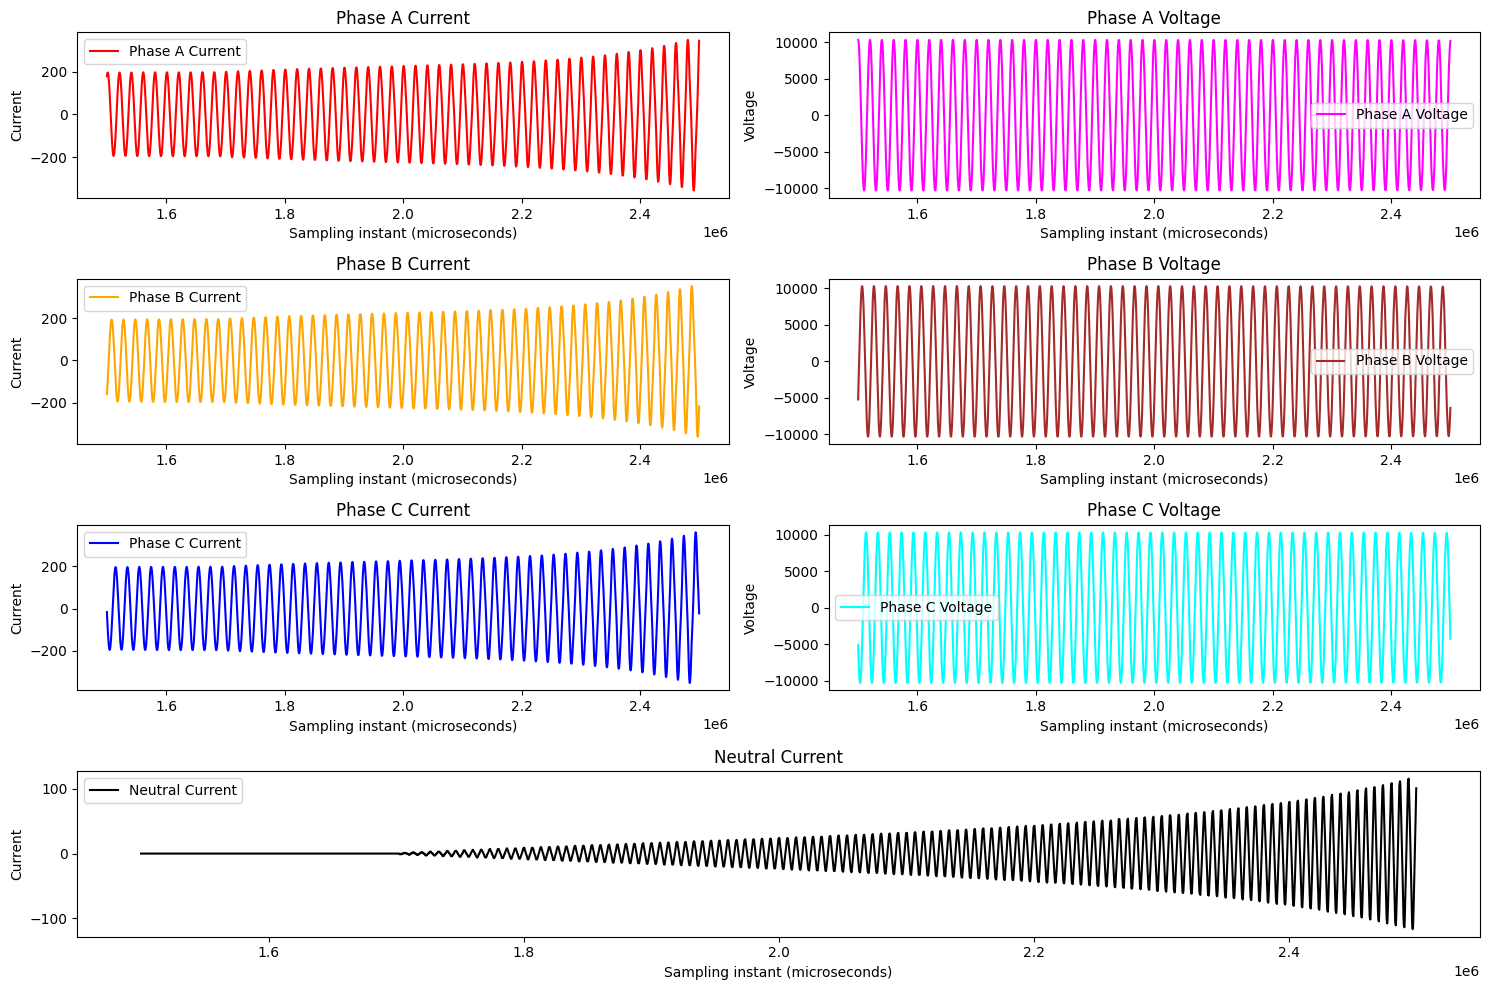

In [14]:
plot_currents_voltages(df_high_impedance_fault)

Signal Count: 7
Sampling Frequency: 4000.0 Hz
Samples Per Cycle: 80
Number of Windows: 1921
Number of Outputs Per Signal: 1921


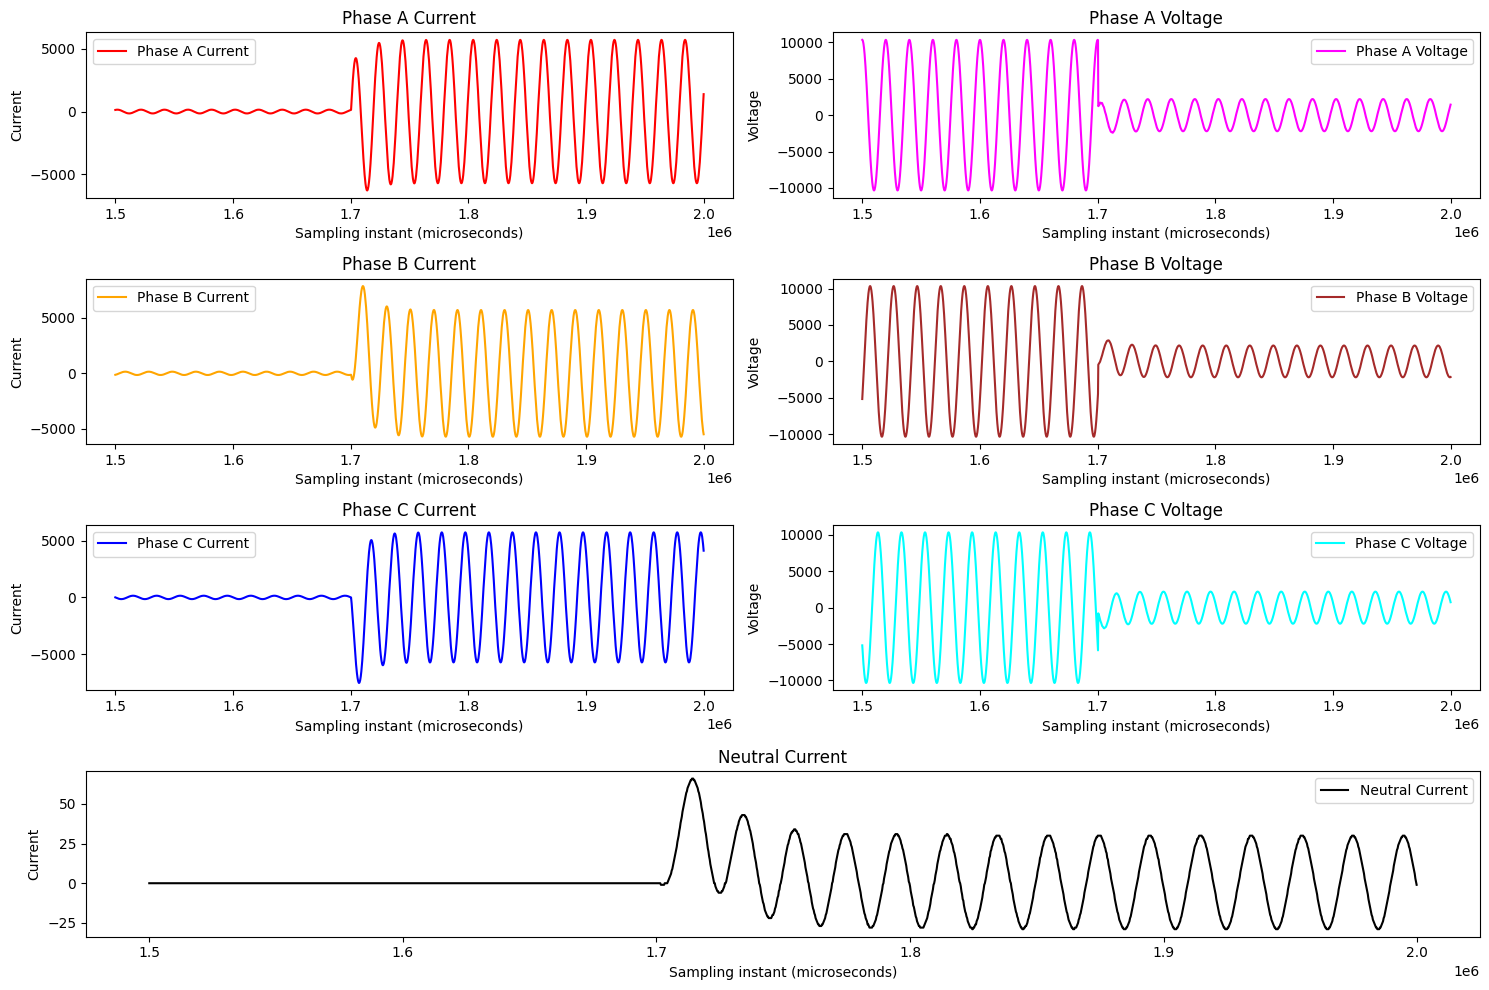

In [15]:
plot_currents_voltages(df_low_impedance_fault)

In [16]:
df_high_impedance_fault_A_current = df_high_impedance_fault.iloc[:,2]
df_high_impedance_fault_A_voltage = df_high_impedance_fault.iloc[:,5]
df_low_impedance_fault_A_current = df_low_impedance_fault.iloc[:,2]
df_low_impedance_fault_A_voltage = df_low_impedance_fault.iloc[:,5]

### **DFT**

In [17]:
def dft(x, window_size, component = 1, all_components = False):

    start_time = time.time()

    N = len(x)
    num_windows = N - window_size + 1  # Calculate number of windows with a stride of 1

    if all_components:
        X = np.zeros((num_windows,window_size), dtype=np.complex128)
    else:
        X = np.zeros(num_windows, dtype=np.complex128)

    # Create matrices for cosine and sine terms
    n = np.arange(window_size)
    k = n.reshape((window_size, 1))
    Wc = np.cos(2 * np.pi * k * n / window_size)
    Ws = np.sin(2 * np.pi * k * n / window_size)

    for i in range(num_windows):

        window = x[i:i + window_size]  # Extract window with stride 1

        Xc = np.dot(Wc, window)
        Xs = np.dot(Ws, window)

        DFT = np.sqrt(2)/window_size * (Xc - 1j * Xs)

        if all_components == False:
            # Take only the required component
            X[i] = DFT[component]
        else:
            X[i] = DFT

    print(f'Running_time : {time.time() - start_time}s')

    return X

In [18]:
def compute_dft_for_all_signals(df, window_size, component = 1):

    start_time = time.time()
    dft_results = {}
    original_signals = {}

    for col in df.columns[2:-1]:  # Exclude first two columns (serial number, sampling instant)
        signal = df[col]
        X = dft(signal, window_size, component)
        running_time = time.time() - start_time
        dft_results[col] = (X, running_time)
        original_signals[col] = signal.values  # Store original signal values

    print(f'Total Running_time : {time.time() - start_time}s')
    return dft_results, original_signals

In [19]:
def plot_results(title,current, dft_current, voltage, dft_voltage, sampling_frequency):

    plt.figure(figsize = (15,3))

    plt.suptitle(title)

    # time = np.arange(0,1/sampling_frequency*len(current),1/sampling_frequency)

    plt.subplot(1,2,1)
    plt.plot(current, label='A Current', color='blue')
    plt.plot(np.abs(dft_current), label='Amplitude of Fundamental', color='orangered')
    plt.title('A Current')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(voltage, label='A Voltage', color='green')
    plt.plot(np.abs(dft_voltage), label='Amplitude of Fundamental', color='red')
    plt.title('A Voltage')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()

**Fundamental Component**

In [20]:
window_size = 80  # Define the window size

sampling_frequency = 4000

dft_high_impedance_fault_A_current = dft(df_high_impedance_fault_A_current,window_size,component = 1)
dft_high_impedance_fault_A_voltage = dft(df_high_impedance_fault_A_voltage,window_size,component = 1)

dft_low_impedance_fault_A_current = dft(df_low_impedance_fault_A_current,window_size,component = 1)
dft_low_impedance_fault_A_voltage = dft(df_low_impedance_fault_A_voltage,window_size,component = 1)

Running_time : 0.4128570556640625s
Running_time : 0.5185797214508057s
Running_time : 0.3284881114959717s
Running_time : 0.28737926483154297s


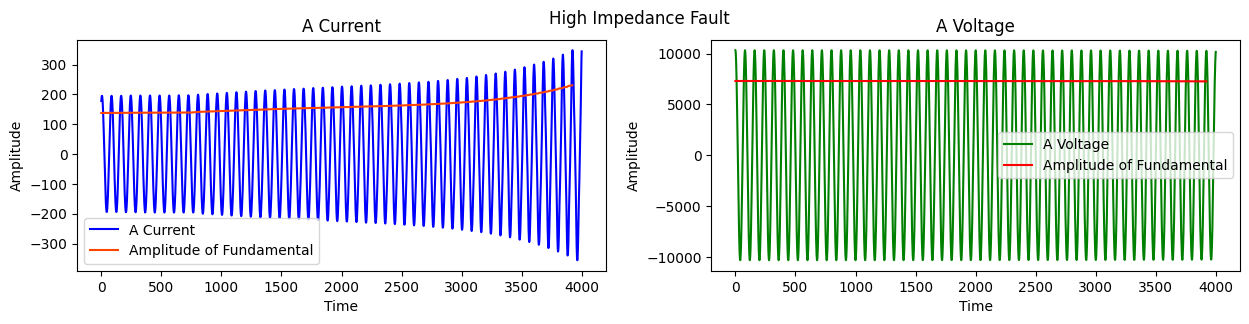

In [21]:
plot_results('High Impedance Fault',df_high_impedance_fault_A_current,dft_high_impedance_fault_A_current,df_high_impedance_fault_A_voltage, dft_high_impedance_fault_A_voltage, sampling_frequency)

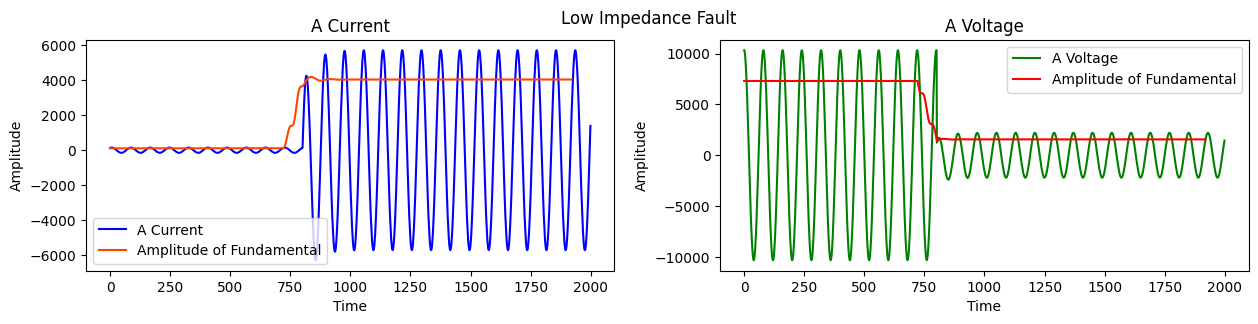

In [22]:
plot_results('Low Impedance Fault',df_low_impedance_fault_A_current,dft_low_impedance_fault_A_current,df_low_impedance_fault_A_voltage, dft_low_impedance_fault_A_voltage, sampling_frequency)

**DC Component**

In [23]:
window_size = 80  # Define the window size

sampling_frequency = 4000

dft_high_impedance_fault_A_current = dft(df_high_impedance_fault_A_current,window_size,component = 0)
dft_high_impedance_fault_A_voltage = dft(df_high_impedance_fault_A_voltage,window_size,component = 0)

dft_low_impedance_fault_A_current = dft(df_low_impedance_fault_A_current,window_size,component = 0)
dft_low_impedance_fault_A_voltage = dft(df_low_impedance_fault_A_voltage,window_size,component = 0)

Running_time : 0.6837437152862549s
Running_time : 0.6334133148193359s
Running_time : 0.17223548889160156s
Running_time : 0.1937873363494873s


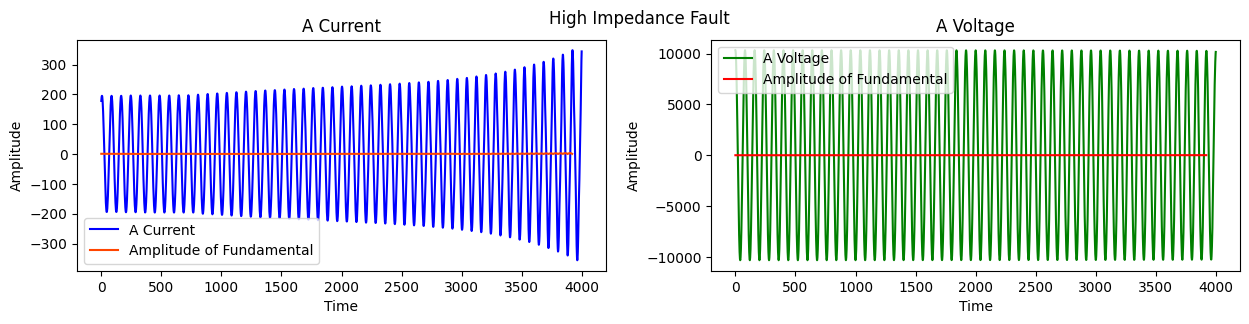

In [24]:
plot_results('High Impedance Fault',df_high_impedance_fault_A_current,dft_high_impedance_fault_A_current,df_high_impedance_fault_A_voltage, dft_high_impedance_fault_A_voltage, sampling_frequency)

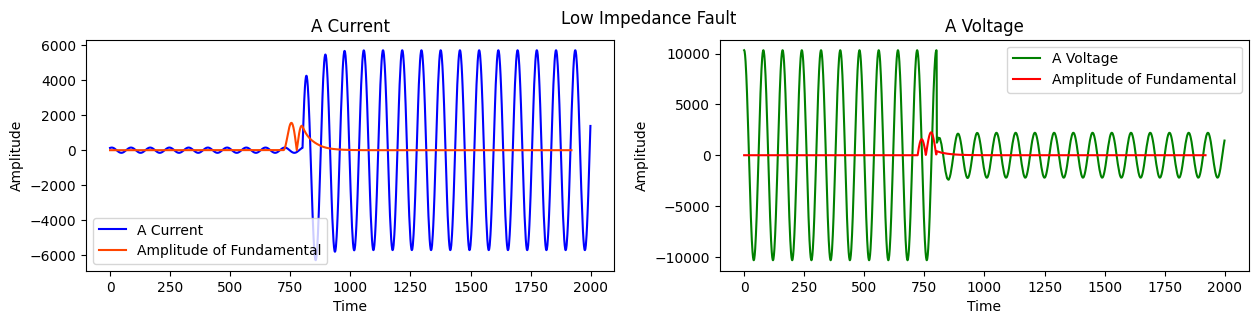

In [25]:
plot_results('Low Impedance Fault',df_low_impedance_fault_A_current,dft_low_impedance_fault_A_current,df_low_impedance_fault_A_voltage, dft_low_impedance_fault_A_voltage, sampling_frequency)

In [26]:
def plot_signals_and_dft(dft_results, original_signals, sampling_frequency, plot_one = False):

    signal_names = {2: "A Current", 3: "B Current", 4: "C Current", 5: "A Voltage", 6: "B Voltage", 7: "C Voltage"}

    num_plots = len(dft_results)
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))

    for i, (signal, (X, _)) in enumerate(dft_results.items()):

        original_signal = original_signals[signal]
        row = i // 2
        col = i % 2

        axes[row, col].plot(original_signal, label='Original Signal', color='blue')
        axes[row, col].plot(np.abs(X), label='Amplitude of Fundamental', color='orangered')
        axes[row, col].set_title(f'{signal_names[signal]} - Original Signal')
        axes[row, col].set_xlabel('Time')
        axes[row, col].set_ylabel('Amplitude')
        axes[row, col].legend()

    plt.tight_layout()
    plt.show()

In [27]:
# window_size = 80  # Define the window size
# sampling_frequency = 1 / (df_high_impedance_fault.iloc[1, 1] - df_high_impedance_fault.iloc[0, 1]) * 1e6  # Sampling frequency in Hz
# dft_results, original_signals = compute_dft_for_all_signals(df_high_impedance_fault, window_size, component = 1)
# plot_signals_and_dft(dft_results, original_signals, sampling_frequency)

In [28]:
# window_size = 80  # Define the window size
# sampling_frequency = 1 / (df_low_impedance_fault.iloc[1, 1] - df_low_impedance_fault.iloc[0, 1]) * 1e6  # Sampling frequency in Hz
# dft_results, original_signals = compute_dft_for_all_signals(df_low_impedance_fault, window_size, component = 1)
# plot_signals_and_dft(dft_results, original_signals, sampling_frequency)

### **Recursive DFT**

In [29]:
def recursive_dft_update(X_prev, x_prev, x_new, k, N):

    # Compute cosine term
    cos_term = np.cos(2 * np.pi * k / N).item()

    # Compute sine term
    sine_term = np.sin(2 * np.pi * k / N).item()

    # Update real part of X_k1

    # Xc_k1_real = X_prev.real + np.sqrt(2)/N * (x_new - x_prev) * cos_term
    # kinda works # Xc_k1_real = cos_term * (np.sqrt(2)/N * (x_new - x_prev) + X_prev.real) + sine_term * (np.sqrt(2)/N * (x_new - x_prev) - X_prev.imag)
    # Xc_k1_real = np.sqrt(2)/N * (x_new * np.cos(2 * np.pi * (N-1) * k / N).item() - x_prev * np.cos(2 * np.pi * k / N).item()) + np.cos(2 * np.pi * k / N).item()*X_prev.real - np.sin(2 * np.pi * k / N).item()*X_prev.imag
    Xc_k1_real = X_prev.real * cos_term + X_prev.imag * sine_term + np.sqrt(2)/N * (x_new - x_prev) * cos_term


    # Compute imaginary part for Xs_k1
    # Xs_k1_imag = X_prev.imag + np.sqrt(2)/N * (x_new - x_prev) * sin_term
    # kinda works # Xs_k1_imag = cos_term * (np.sqrt(2)/N * (x_new - x_prev) - X_prev.imag) - sine_term * (np.sqrt(2)/N * (x_new - x_prev) + X_prev.real)
    # Xs_k1_imag = np.sqrt(2)/N * (x_new * np.sin(2 * np.pi * (N-1) * k / N).item() - x_prev * np.sin(2 * np.pi * k / N).item()) - np.cos(2 * np.pi * k / N).item()*X_prev.imag - np.sin(2 * np.pi * k / N).item()*X_prev.real
    Xs_k1_imag = X_prev.real * sine_term - X_prev.imag * cos_term + np.sqrt(2)/N * (x_new - x_prev) * sine_term


    # Compute updated DFT coefficient X_k1
    X_k1 = Xc_k1_real - 1j * Xs_k1_imag

    return X_k1

def recursive_dft(signal, window_size, component = 1):

    num_samples = signal.shape[0]
    n_windows = num_samples - window_size + 1

    X = np.zeros(n_windows, dtype=np.complex128)  # Initialize DFT coefficients

    # For all windows
    for i in range(n_windows):

        if i == 0:
            # First DFT
            X[i] = dft(signal[i:i + window_size], window_size, component).item()

        else:
            # Compute x_new for the current frequency bin k
            x_new = signal[i + window_size - 1]
            x_prev = signal[i - 1]
            X[i] = recursive_dft_update(X[i-1], x_prev, x_new, k=component, N=window_size)

    return X

In [30]:
def compute_recursive_dft_for_all_signals(df, window_size, component = 1):

    start_time = time.time()
    dft_results = {}
    original_signals = {}

    for col in df.columns[2:-1]:  # Exclude first two columns (serial number, sampling instant)
        signal = df[col]
        X = recursive_dft(signal, window_size, component)
        running_time = time.time() - start_time
        dft_results[col] = (X, running_time)
        original_signals[col] = signal.values  # Store original signal values

    print(f'Total Running_time : {time.time() - start_time}s')
    return dft_results, original_signals

**Fundamental Component**

In [31]:
window_size = 80  # Define the window size

sampling_frequency = 4000

recursive_dft_high_impedance_fault_A_current = recursive_dft(df_high_impedance_fault_A_current,window_size,component = 1)
recursive_dft_high_impedance_fault_A_voltage = recursive_dft(df_high_impedance_fault_A_voltage,window_size,component = 1)

recursive_dft_low_impedance_fault_A_current = recursive_dft(df_low_impedance_fault_A_current,window_size,component = 1)
recursive_dft_low_impedance_fault_A_voltage = recursive_dft(df_low_impedance_fault_A_voltage,window_size,component = 1)

Running_time : 0.0009167194366455078s
Running_time : 0.0005431175231933594s
Running_time : 0.00058746337890625s
Running_time : 0.0019130706787109375s


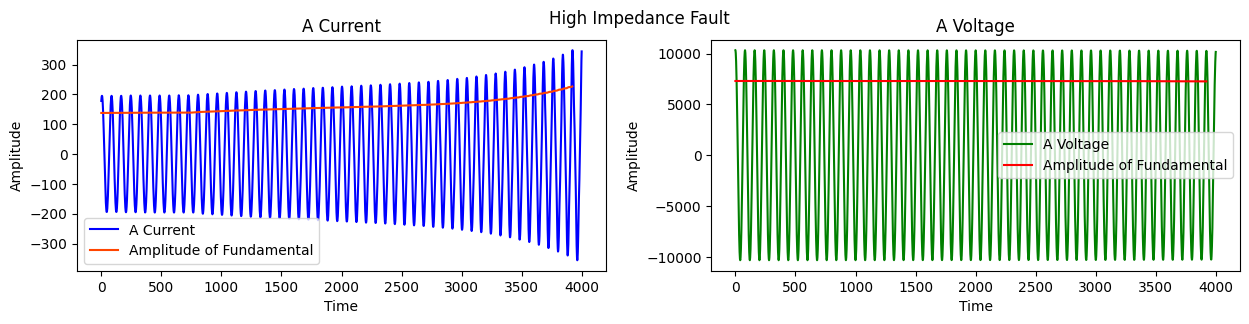

In [32]:
plot_results('High Impedance Fault',df_high_impedance_fault_A_current,recursive_dft_high_impedance_fault_A_current,df_high_impedance_fault_A_voltage, recursive_dft_high_impedance_fault_A_voltage, sampling_frequency)

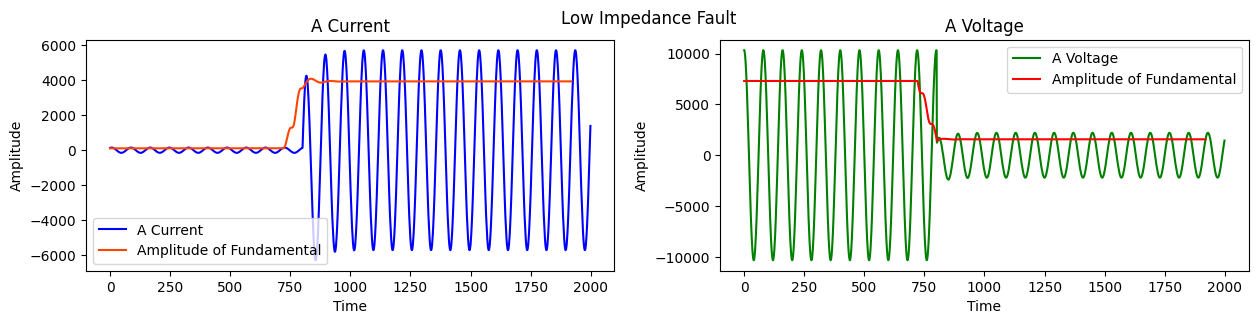

In [33]:
plot_results('Low Impedance Fault',df_low_impedance_fault_A_current,recursive_dft_low_impedance_fault_A_current,df_low_impedance_fault_A_voltage, recursive_dft_low_impedance_fault_A_voltage, sampling_frequency)

**DC Component**

In [34]:
window_size = 80  # Define the window size

sampling_frequency = 4000

dft_high_impedance_fault_A_current = recursive_dft(df_high_impedance_fault_A_current,window_size,component = 0)
dft_high_impedance_fault_A_voltage = recursive_dft(df_high_impedance_fault_A_voltage,window_size,component = 0)

dft_low_impedance_fault_A_current = recursive_dft(df_low_impedance_fault_A_current,window_size,component = 0)
dft_low_impedance_fault_A_voltage = recursive_dft(df_low_impedance_fault_A_voltage,window_size,component = 0)

Running_time : 0.0008270740509033203s
Running_time : 0.0006902217864990234s
Running_time : 0.0005755424499511719s
Running_time : 0.0008919239044189453s


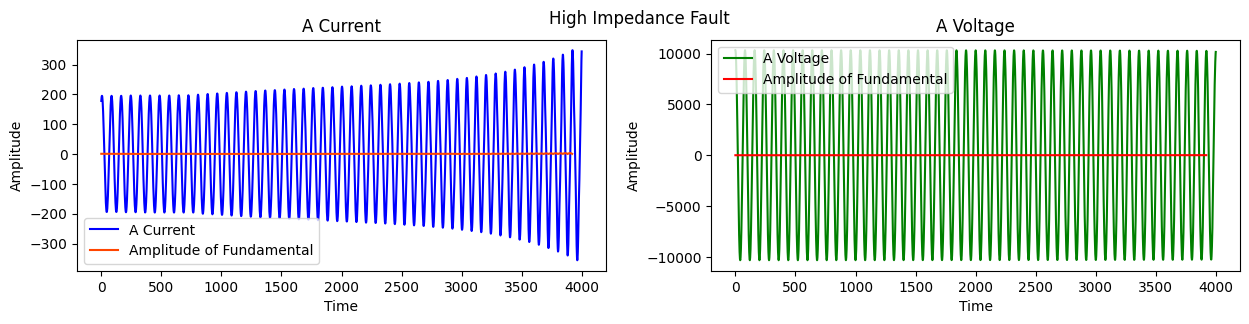

In [35]:
plot_results('High Impedance Fault',df_high_impedance_fault_A_current,dft_high_impedance_fault_A_current,df_high_impedance_fault_A_voltage, dft_high_impedance_fault_A_voltage, sampling_frequency)

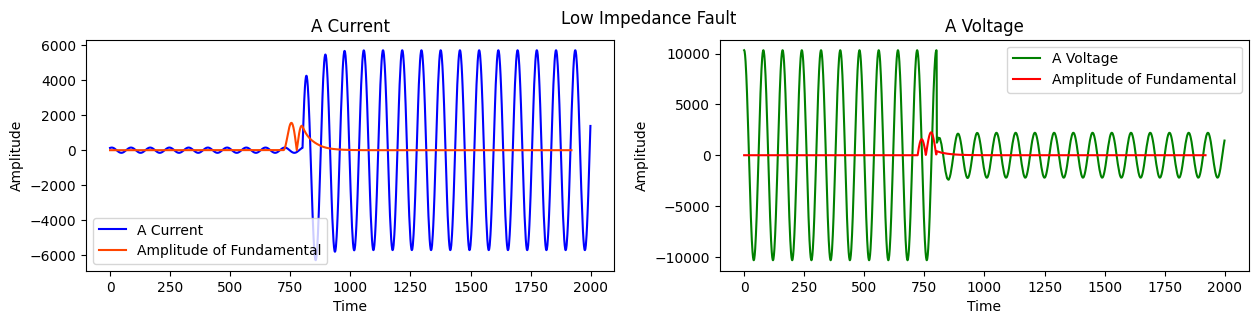

In [36]:
plot_results('Low Impedance Fault',df_low_impedance_fault_A_current,dft_low_impedance_fault_A_current,df_low_impedance_fault_A_voltage, dft_low_impedance_fault_A_voltage, sampling_frequency)

In [37]:
# window_size = 80  # Define the window size
# sampling_frequency = 1 / (df_high_impedance_fault.iloc[1, 1] - df_high_impedance_fault.iloc[0, 1]) * 1e6  # Sampling frequency in Hz
# dft_results_high, original_signals_high = compute_recursive_dft_for_all_signals(df_high_impedance_fault, window_size, component = 1)
# plot_signals_and_dft(dft_results_high, original_signals_high, sampling_frequency)

In [38]:
# window_size = 80  # Define the window size
# sampling_frequency = 1 / (df_low_impedance_fault.iloc[1, 1] - df_low_impedance_fault.iloc[0, 1]) * 1e6  # Sampling frequency in Hz
# dft_results_low, original_signals_low = compute_recursive_dft_for_all_signals(df_low_impedance_fault, window_size, component = 1)
# plot_signals_and_dft(dft_results_low, original_signals_low, sampling_frequency)

In [39]:
fault_detection_time_ied = 200.25
base_current = np.abs(np.mean(recursive_dft_high_impedance_fault_A_current[:2]))
indices = np.where(np.abs(recursive_dft_high_impedance_fault_A_current) > (2 * base_current))[0]

if indices.size > 0:
    fault_crossing_threshold = indices[0] * 1 / sampling_frequency * 1e3
    if fault_crossing_threshold >= 0:
        delay = fault_detection_time_ied - fault_crossing_threshold
        print(f'High Impedance Fault : Delay from Fault Inception : {delay if delay > 0 else "No Fault Detected!!"}')
    else:
        print(f'High Impedance Fault : Delay from Fault Inception : No Fault Detected!!')
else:
    print(f'High Impedance Fault : Delay from Fault Inception : No Fault Detected!!')

High Impedance Fault : Delay from Fault Inception : No Fault Detected!!


In [40]:
fault_detection_time_ied = 200.25
base_current = np.abs(np.mean(recursive_dft_low_impedance_fault_A_current[:2]))
fault_crossing_threshold = np.where((np.abs(recursive_dft_low_impedance_fault_A_current) > (2 * base_current)) == 1)[0][0] * 1 / sampling_frequency * 1e3
print(f'Low Impedance Fault : Delay from Fault Inception : {fault_detection_time_ied - fault_crossing_threshold}ms')

Low Impedance Fault : Delay from Fault Inception : 18.25ms


### **Short-time DFT - half cycle and quarter cycle**

#### **Half Cycle DFT**

In [41]:
window_size = 40  # Define the window size

sampling_frequency = 4000

half_cycle_dft_high_impedance_fault_A_current = recursive_dft(df_high_impedance_fault_A_current,window_size,component = 0)
half_cycle_dft_high_impedance_fault_A_voltage = recursive_dft(df_high_impedance_fault_A_voltage,window_size,component = 0)

half_cycle_dft_low_impedance_fault_A_current = recursive_dft(df_low_impedance_fault_A_current,window_size,component = 0)
half_cycle_dft_low_impedance_fault_A_voltage = recursive_dft(df_low_impedance_fault_A_voltage,window_size,component = 0)

Running_time : 0.0006926059722900391s
Running_time : 0.0003025531768798828s
Running_time : 0.0002899169921875s
Running_time : 0.0002930164337158203s


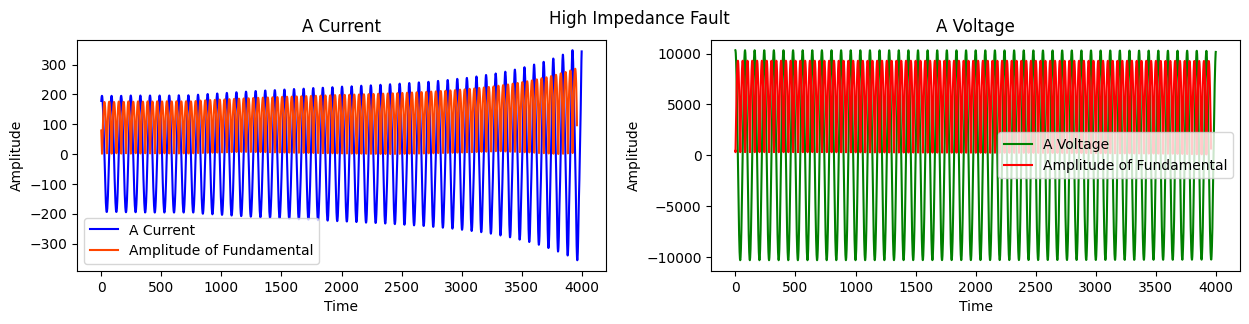

In [42]:
plot_results('High Impedance Fault',df_high_impedance_fault_A_current,half_cycle_dft_high_impedance_fault_A_current,df_high_impedance_fault_A_voltage, half_cycle_dft_high_impedance_fault_A_voltage, sampling_frequency)

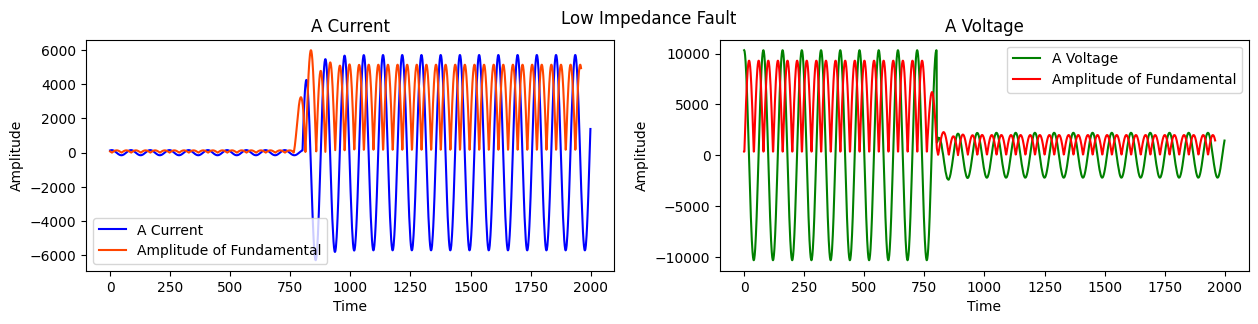

In [43]:
plot_results('Low Impedance Fault',df_low_impedance_fault_A_current,half_cycle_dft_low_impedance_fault_A_current,df_low_impedance_fault_A_voltage, half_cycle_dft_low_impedance_fault_A_voltage, sampling_frequency)

In [44]:
fault_detection_time_ied = 200.25
base_current = np.abs(np.max(half_cycle_dft_high_impedance_fault_A_current[:100]) / np.sqrt(2))
indices = np.where(np.abs(half_cycle_dft_high_impedance_fault_A_current) > (2 * base_current))[0]

if indices.size > 0:
    fault_crossing_threshold = indices[0] * 1 / sampling_frequency * 1e3
    if fault_crossing_threshold >= 0:
        delay = fault_detection_time_ied - fault_crossing_threshold
        print(f'High Impedance Fault : Delay from Fault Inception : {delay if delay > 0 else "No Fault Detected!!"}')
    else:
        print(f'High Impedance Fault : Delay from Fault Inception : No Fault Detected!!')
else:
    print(f'High Impedance Fault : Delay from Fault Inception : No Fault Detected!!')

High Impedance Fault : Delay from Fault Inception : No Fault Detected!!


In [45]:
fault_detection_time_ied = 200.25
base_current = np.abs(np.max(half_cycle_dft_low_impedance_fault_A_current[:100]) / np.sqrt(2))
fault_crossing_threshold = np.where((np.abs(half_cycle_dft_low_impedance_fault_A_current) > (2 * base_current)) == 1)[0][0] * 1 / sampling_frequency * 1e3
print(f'Low Impedance Fault : Delay from Fault Inception : {fault_detection_time_ied - fault_crossing_threshold}ms')

Low Impedance Fault : Delay from Fault Inception : 8.5ms


In [46]:
# window_size = 40  # Define the window size
# # sampling_frequency = 1 / (df_high_impedance_fault.iloc[1, 1] - df_high_impedance_fault.iloc[0, 1]) * 1e6  # Sampling frequency in Hz
# dft_results_high_half, original_signals_high_half = compute_dft_for_all_signals(df_high_impedance_fault, window_size, component = 0)
# plot_signals_and_dft(dft_results_high_half, original_signals_high_half, sampling_frequency)

In [47]:
# window_size = 40  # Define the window size
# sampling_frequency = 1 / (df_low_impedance_fault.iloc[1, 1] - df_low_impedance_fault.iloc[0, 1]) * 1e6  # Sampling frequency in Hz
# dft_results_low_half, original_signals_low_half = compute_dft_for_all_signals(df_low_impedance_fault, window_size, component = 0)
# plot_signals_and_dft(dft_results_low_half, original_signals_low_half, sampling_frequency)

#### **Quarter Cycle DFT**

In [48]:
window_size = 20  # Define the window size

sampling_frequency = 4000

quarter_cycle_dft_high_impedance_fault_A_current = recursive_dft(df_high_impedance_fault_A_current,window_size,component = 0)
quarter_cycle_dft_high_impedance_fault_A_voltage = recursive_dft(df_high_impedance_fault_A_voltage,window_size,component = 0)

quarter_cycle_dft_low_impedance_fault_A_current = recursive_dft(df_low_impedance_fault_A_current,window_size,component = 0)
quarter_cycle_dft_low_impedance_fault_A_voltage = recursive_dft(df_low_impedance_fault_A_voltage,window_size,component = 0)

Running_time : 0.00046372413635253906s
Running_time : 0.0002319812774658203s
Running_time : 0.00023245811462402344s
Running_time : 0.0002593994140625s


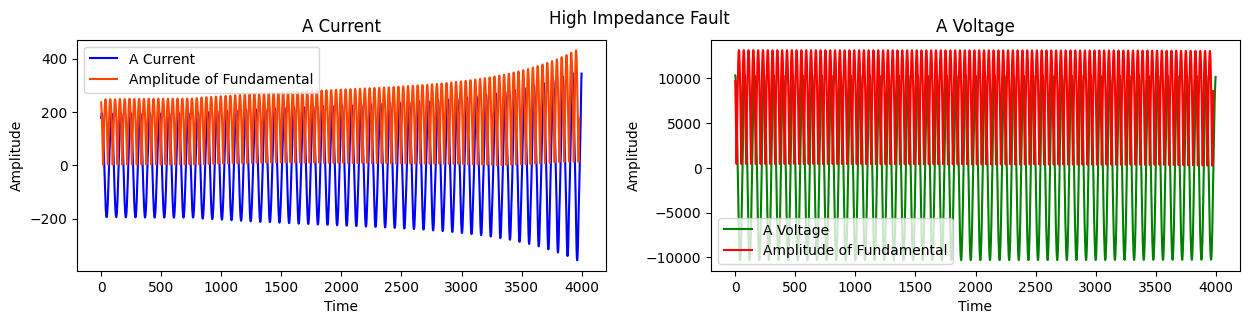

In [49]:
plot_results('High Impedance Fault',df_high_impedance_fault_A_current,quarter_cycle_dft_high_impedance_fault_A_current,df_high_impedance_fault_A_voltage, quarter_cycle_dft_high_impedance_fault_A_voltage, sampling_frequency)

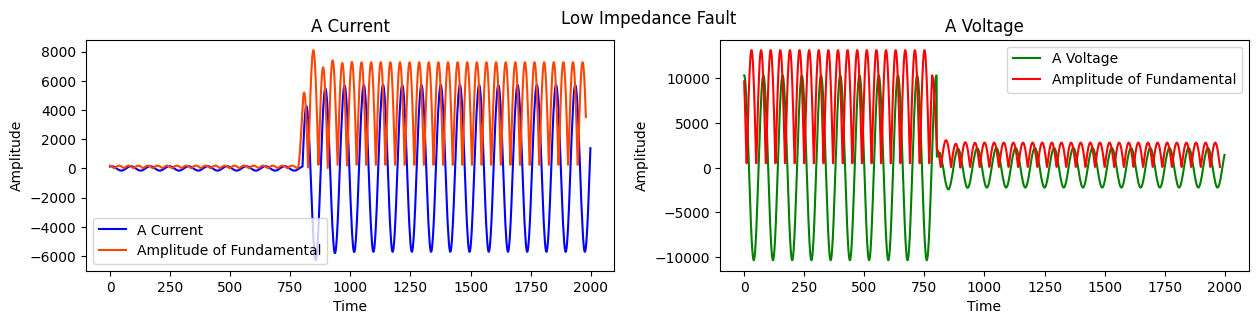

In [50]:
plot_results('Low Impedance Fault',df_low_impedance_fault_A_current,quarter_cycle_dft_low_impedance_fault_A_current,df_low_impedance_fault_A_voltage, quarter_cycle_dft_low_impedance_fault_A_voltage, sampling_frequency)

In [51]:
fault_detection_time_ied = 200.25
base_current = np.abs(np.max(quarter_cycle_dft_high_impedance_fault_A_current[:100]) / np.sqrt(2))
indices = np.where(np.abs(quarter_cycle_dft_high_impedance_fault_A_current) > (2 * base_current))[0]

if indices.size > 0:
    fault_crossing_threshold = indices[0] * 1 / sampling_frequency * 1e3
    if fault_crossing_threshold >= 0:
        delay = fault_detection_time_ied - fault_crossing_threshold
        print(f'High Impedance Fault : Delay from Fault Inception : {delay if delay > 0 else "No Fault Detected!!"}')
    else:
        print(f'High Impedance Fault : Delay from Fault Inception : No Fault Detected!!')
else:
    print(f'High Impedance Fault : Delay from Fault Inception : No Fault Detected!!')

High Impedance Fault : Delay from Fault Inception : No Fault Detected!!


In [52]:
fault_detection_time_ied = 200.25
base_current = np.abs(np.max(quarter_cycle_dft_low_impedance_fault_A_current[:100]) / np.sqrt(2))
fault_crossing_threshold = np.where((np.abs(quarter_cycle_dft_low_impedance_fault_A_current) > (2 * base_current)) == 1)[0][0] * 1 / sampling_frequency * 1e3
print(f'Low Impedance Fault : Delay from Fault Inception : {fault_detection_time_ied - fault_crossing_threshold}ms')

Low Impedance Fault : Delay from Fault Inception : 4.0ms


In [53]:
# window_size = 20  # Define the window size
# # sampling_frequency = 1 / (df_high_impedance_fault.iloc[1, 1] - df_high_impedance_fault.iloc[0, 1]) * 1e6  # Sampling frequency in Hz
# dft_results_high_half, original_signals_high_half = compute_dft_for_all_signals(df_high_impedance_fault, window_size, component = 0)
# plot_signals_and_dft(dft_results_high_half, original_signals_high_half, sampling_frequency)

In [54]:
# window_size = 20  # Define the window size
# sampling_frequency = 1 / (df_low_impedance_fault.iloc[1, 1] - df_low_impedance_fault.iloc[0, 1]) * 1e6  # Sampling frequency in Hz
# dft_results_low_half, original_signals_low_half = compute_dft_for_all_signals(df_low_impedance_fault, window_size, component = 0)
# plot_signals_and_dft(dft_results_low_half, original_signals_low_half, sampling_frequency)

### **Frequency Estimation**

In [63]:
def estimate_frequency_trend(voltage_data, sampling_rate, stride = 1, window_size=None, window_func=None):

    """

    Estimates the frequency trend of a power supply using DFT.

    Args:

        voltage_data (np.array): Voltage waveform data.

        sampling_rate (float): Sampling rate of the voltage data (Hz).

        window_size (int, optional): Size of the sliding window for trend estimation. Defaults to None (no windowing).

        window_func (function, optional): Window function to apply before DFT. Defaults to None (no windowing).

    Returns:

        tuple: (frequencies, time_stamps)

            frequencies (np.array): Array of estimated dominant frequencies for each window.

            time_stamps (np.array): Array of corresponding time stamps for each window.

    """

    # Define window function (if provided)

    if window_func is not None:

        window = window_func(window_size)

    else:

        window = np.ones(window_size)

    # Sliding window and frequency estimation

    frequencies = []

    time_stamps = []

    if window_size is None:

        # Single DFT for entire data

        fft = np.fft.fft(voltage_data * window)

        dominant_freq = np.abs(fft).argmax() / len(voltage_data) * sampling_rate

        frequencies.append(dominant_freq)

        time_stamps.append(len(voltage_data) / sampling_rate)

    else:

        # Sliding window approach

        for i in range(0, len(voltage_data) - window_size + 1, stride):

            windowed_data = voltage_data[i:i+window_size] * window

            fft = np.fft.fft(windowed_data)[1:]

            dominant_freq = (np.abs(fft).argmax() + 1) * (sampling_rate / window_size)

            dominant_freq = min(dominant_freq, sampling_rate - dominant_freq)

            frequencies.append(dominant_freq/2)

            time_stamps.append(i / sampling_rate)

    return np.array(frequencies), np.array(time_stamps)

In [64]:
def plot_signals(title, estimated_freq, voltage_waveform):

    fig, axes = plt.subplots(2, 1, figsize=(15, 6))

    fig.suptitle(title)

    # Plot estimated frequency trend
    axes[0].plot(estimated_freq, color='blue', label='Estimated Frequency')
    axes[0].set_ylabel('Frequency (Hz)')
    axes[0].legend()

    # Plot original voltage waveform
    axes[1].plot(voltage_waveform, color='orangered', label='Voltage Waveform')
    axes[1].set_ylabel('Amplitude')
    axes[1].legend()

    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()

In [65]:
estimated_freq_high_impedance, time_stamps = estimate_frequency_trend(df_high_impedance_fault_A_voltage, sampling_rate=4000, window_size=40, window_func=None)

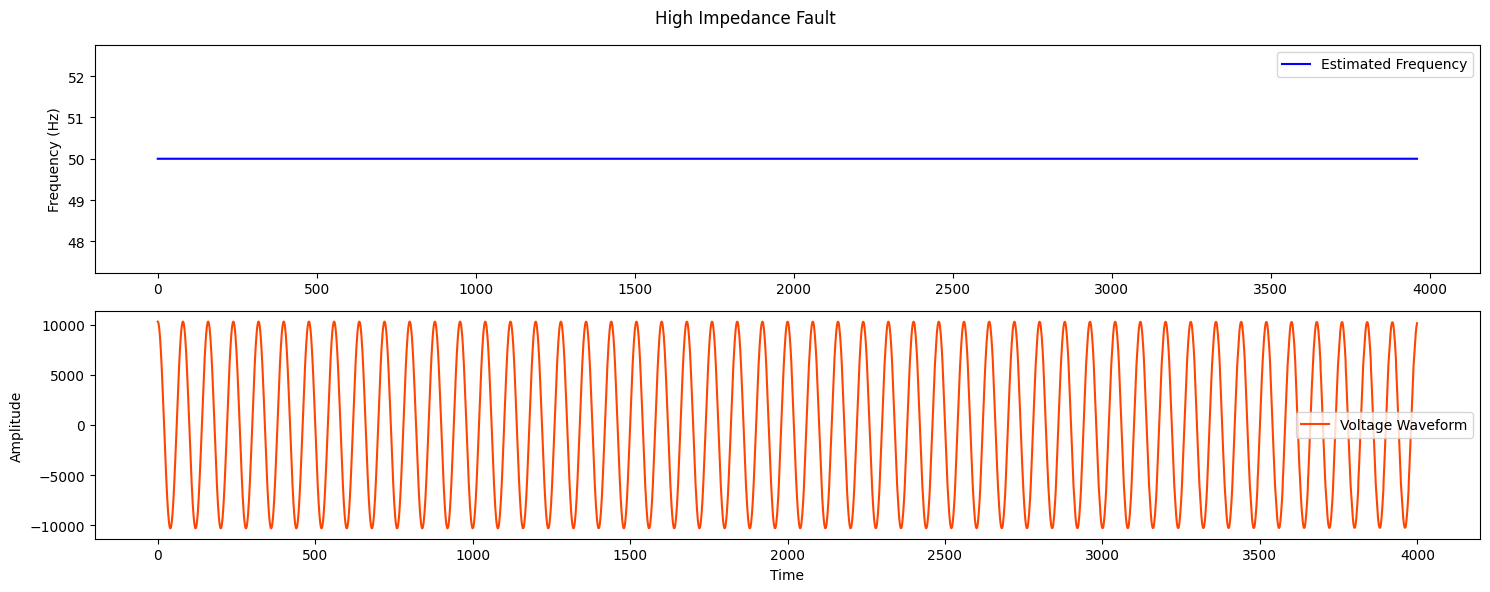

In [66]:
plot_signals('High Impedance Fault', estimated_freq_high_impedance, voltage_waveform = df_high_impedance_fault_A_voltage)

In [67]:
estimated_freq_low_impedance, time_stamps = estimate_frequency_trend(df_low_impedance_fault_A_voltage, sampling_rate=4000, window_size=40)

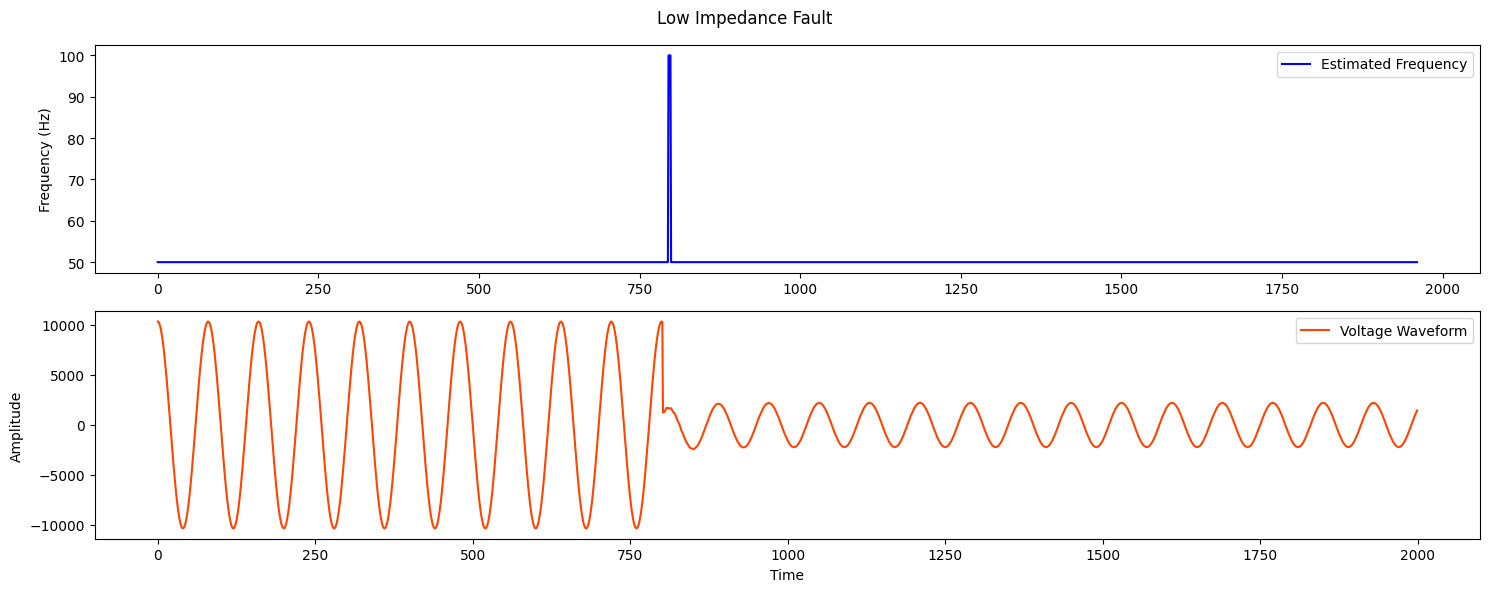

In [68]:
plot_signals('Low Impedance Fault', estimated_freq_low_impedance, voltage_waveform = df_low_impedance_fault_A_voltage)

## **Q2**

Switching On of large loads such as transformers causes inrush phenomena in the network. This will cause the non-fundamental frequency to present in the voltages and currents (fundamental is 50Hz). Power electronic devices introduce non-sinusoidal currents (mainly when not compensated). These are due to the non-linearities involved in the equipment and might cause the relays to pick up even though the events are Power Quality events, not faults. Files are in `Signal_files\1.Switch On`

### **Loading Data**

In [71]:
rectifier_without_cap = pd.read_fwf('/content/drive/MyDrive/E9 222 Signal Processing in Practice Assignments/Assignment - 17 | Power Systems | 08-04-2024/Data/1.Switch On/Rectifier/rectifier no cap.txt')
transformer_with_load_10 = pd.read_fwf('/content/drive/MyDrive/E9 222 Signal Processing in Practice Assignments/Assignment - 17 | Power Systems | 08-04-2024/Data/1.Switch On/Transformer/trafo with load 10.txt')

In [72]:
cols = ['X axis',
 'YD_1/xfmr_A/RL1',
 'YD_1/xfmr_B/RL1',
 'YD_1/xfmr_C/RL1',
 'm1a',
 'm1b',
 'm1c',
 'm2a',
 'm2b',
 'm2c',
]
# cols = cols[0:1] + cols[10:] + cols[1:4] + cols[4:10]
transformer_with_load_10 = transformer_with_load_10[cols]

In [73]:
rectifier_without_cap = rectifier_without_cap.apply(pd.to_numeric, errors='coerce')
transformer_with_load_10 = transformer_with_load_10.apply(pd.to_numeric, errors='coerce')

In [74]:
rectifier_time_steps = rectifier_without_cap['X axis'][1:].to_numpy()
rectifier_without_cap_current =  rectifier_without_cap['DY_1/xfmr_A/RL1'][1:].to_numpy()
rectifier_without_cap_m1_voltage =  rectifier_without_cap['m1a'][1:].to_numpy()
rectifier_without_cap_m2_voltage =  rectifier_without_cap['m2a'][1:].to_numpy()

In [75]:
tranformer_time_steps = transformer_with_load_10['X axis'][1:].to_numpy()
transformer_with_load_10_current =  transformer_with_load_10['YD_1/xfmr_A/RL1'][1:].to_numpy()
transformer_with_load_10_m1_voltage =  transformer_with_load_10['m1a'][1:].to_numpy()
transformer_with_load_10_m2_voltage =  transformer_with_load_10['m2a'][1:].to_numpy()

In [76]:
def plot_currents_voltages(df):

    # Extract data
    sampling_frequency = round(1 / (df.iloc[2, 0] - df.iloc[1, 0]))  # Sampling frequency in Hz
    samples_per_cycle = int(sampling_frequency / 50)  # Samples per cycle
    signal_count = df.shape[1] - 1  # Number of signals (currents and voltages excluding first column)
    window_size = samples_per_cycle
    number_of_windows = df.shape[0] - window_size # Number of windows
    number_of_outputs_per_signal = number_of_windows

    print("Signal Count:", signal_count)
    print("Sampling Frequency:", sampling_frequency, "Hz")
    print("Samples Per Cycle:", samples_per_cycle)
    print("Number of Windows:", number_of_windows)
    print("Number of Outputs Per Signal:", number_of_outputs_per_signal)

    # Plotting
    plt.figure(figsize=(15, 10))

    # Plot currents and voltages for each phase
    for i in range(3):

        plt.subplot(3, 3, i * 3 + 1)  # Current subplot
        plt.plot(df.iloc[1:, 0], df.iloc[1:, i + 1], label=f'Phase {chr(97 + i)} Current', color='blue')
        plt.xlabel('Sampling instant (seconds)')
        plt.ylabel('Current (A)')
        plt.title(f'Phase {chr(97 + i)} Current')
        plt.legend()

        plt.subplot(3, 3, i * 3 + 2)  # m1 Voltage subplot
        plt.plot(df.iloc[1:, 0], df.iloc[1:, i + 4], label=f'm1{chr(97 + i)} Voltage', color='orangered')
        plt.xlabel('Sampling instant (seconds)')
        plt.ylabel('Voltage (V)')
        plt.title(f'm1{chr(97 + i)} Voltage')
        plt.legend()

        plt.subplot(3, 3, i * 3 + 3)  # m2 Voltage subplot
        plt.plot(df.iloc[1:, 0], df.iloc[1:, i + 7], label=f'm2{chr(97 + i)} Voltage', color='orangered')
        plt.xlabel('Sampling instant (seconds)')
        plt.ylabel('Voltage (V)')
        plt.title(f'm2{chr(97 + i)} Voltage')
        plt.legend()

    plt.tight_layout()
    plt.show()

Signal Count: 9
Sampling Frequency: 200000 Hz
Samples Per Cycle: 4000
Number of Windows: 297685
Number of Outputs Per Signal: 297685


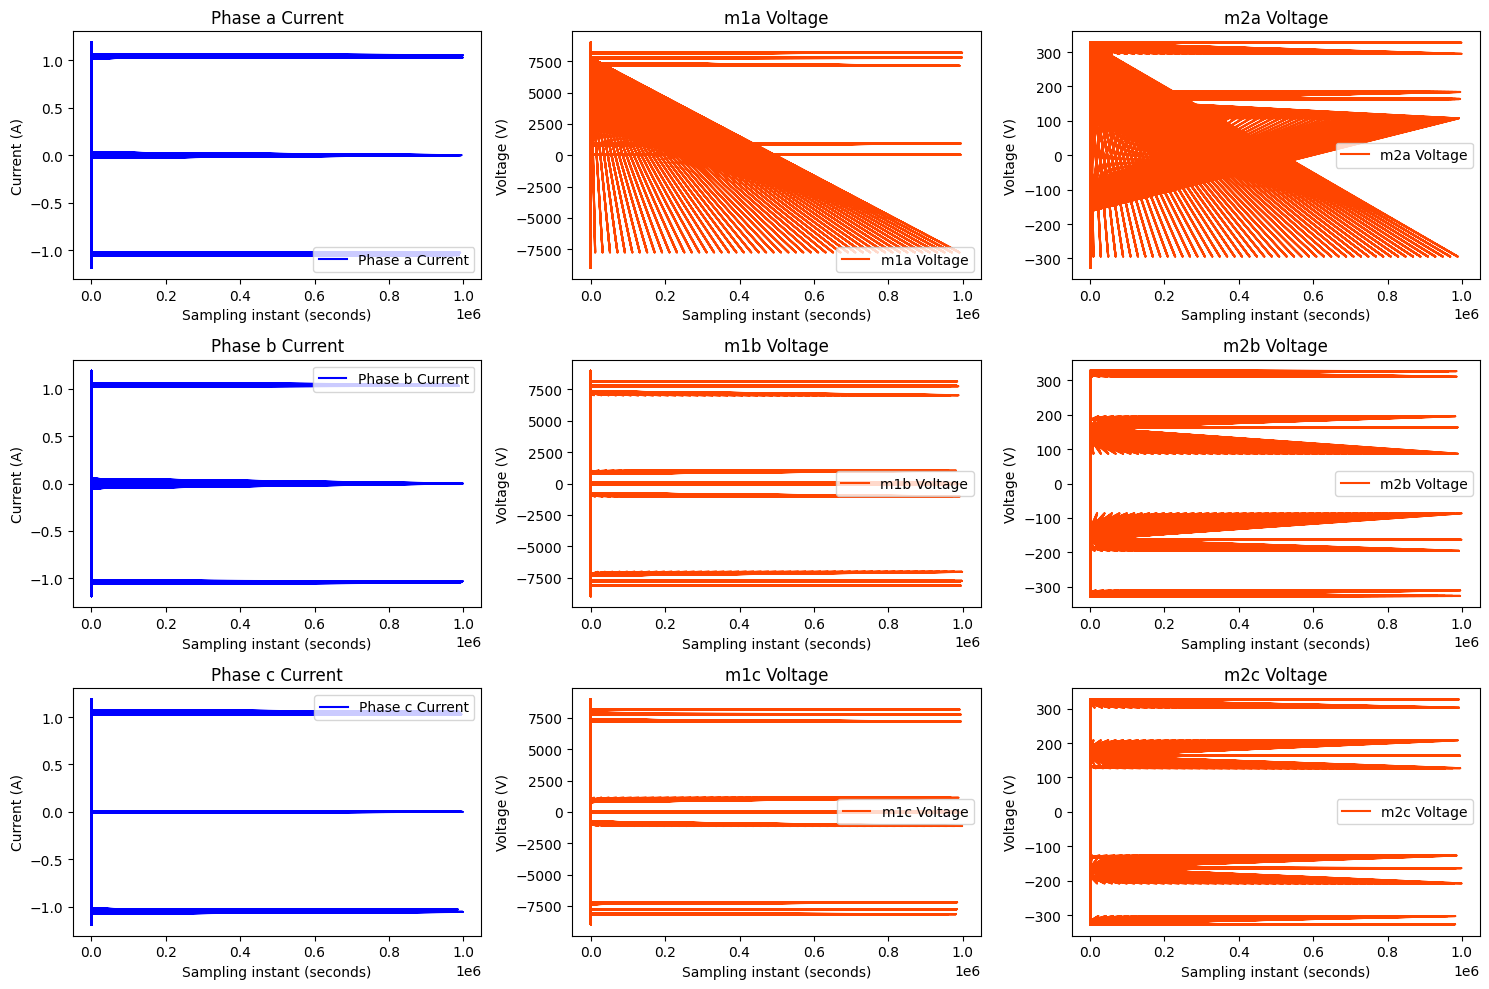

In [77]:
plot_currents_voltages(rectifier_without_cap)

Signal Count: 9
Sampling Frequency: 200000 Hz
Samples Per Cycle: 4000
Number of Windows: 96287
Number of Outputs Per Signal: 96287


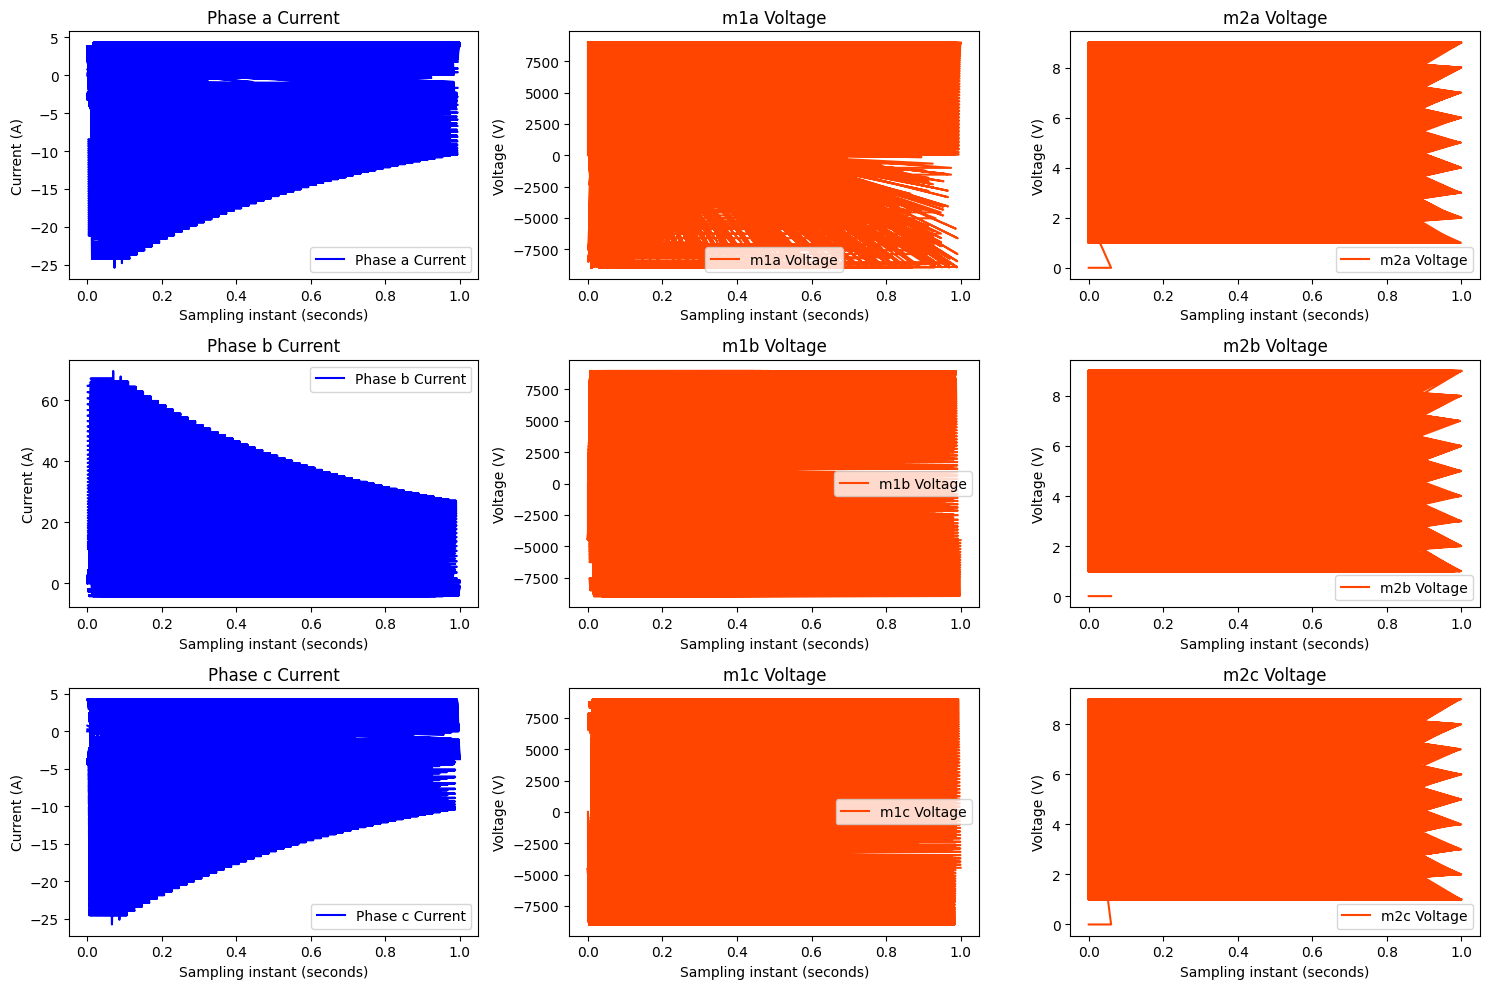

In [78]:
plot_currents_voltages(transformer_with_load_10)

### **DFT**

In [79]:
window_size = 4000  # Define the window size

sampling_frequency = 200000

dft_rectifier_without_cap_current = recursive_dft(rectifier_without_cap_current,window_size,component = 2)
dft_rectifier_without_cap_m1_voltage = recursive_dft(rectifier_without_cap_m1_voltage,window_size,component = 2)
dft_rectifier_without_cap_m2_voltage = recursive_dft(rectifier_without_cap_m2_voltage,window_size,component = 2)

Running_time : 0.7820415496826172s
Running_time : 0.9250926971435547s
Running_time : 1.3628180027008057s


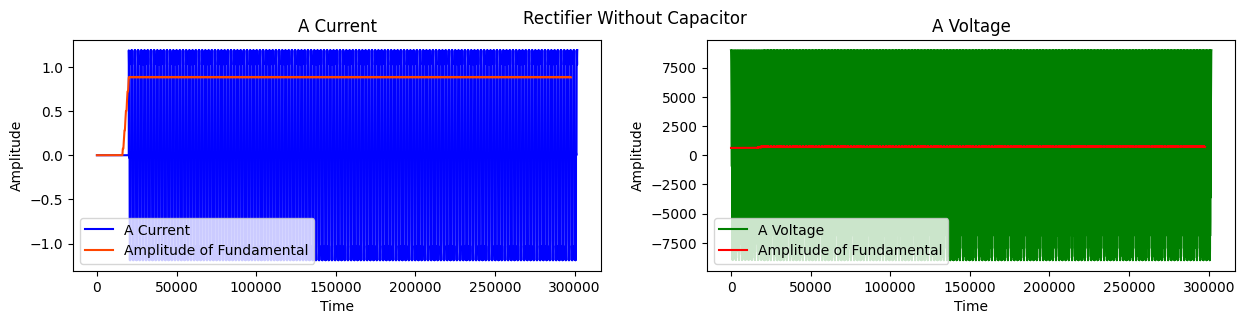

In [80]:
plot_results('Rectifier Without Capacitor',rectifier_without_cap_current,dft_rectifier_without_cap_current,rectifier_without_cap_m1_voltage, dft_rectifier_without_cap_m1_voltage, sampling_frequency)

In [81]:
window_size = 4000  # Define the window size

sampling_frequency = 200000

dft_transformer_with_load_10_current = recursive_dft(transformer_with_load_10_current,window_size,component = 2)
dft_transformer_with_load_10_m1_voltage = recursive_dft(transformer_with_load_10_m1_voltage,window_size,component = 1)
dft_transformer_with_load_10_m2_voltage = recursive_dft(transformer_with_load_10_m2_voltage,window_size,component = 1)

Running_time : 0.7554552555084229s
Running_time : 0.7235226631164551s
Running_time : 1.1129193305969238s


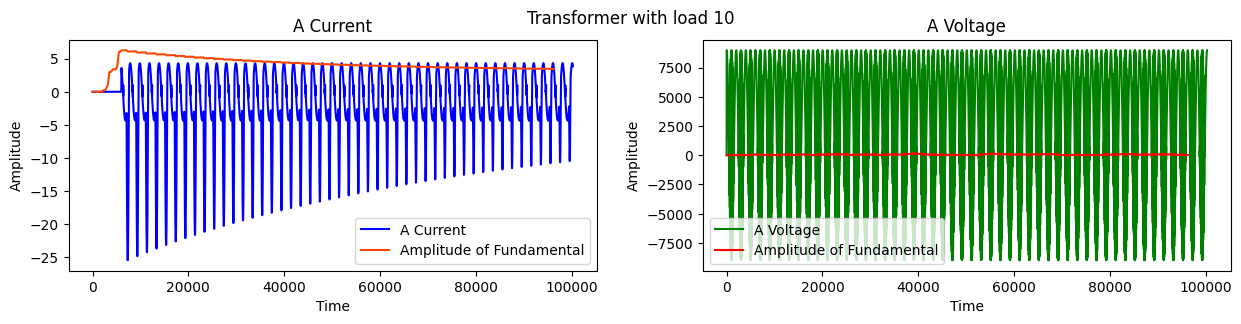

In [82]:
plot_results('Transformer with load 10',transformer_with_load_10_current,dft_transformer_with_load_10_current,transformer_with_load_10_m1_voltage, dft_transformer_with_load_10_m1_voltage, sampling_frequency)

### **Harmonics**

In [92]:
def compute_thd(fft_freq, fft_mag, fundamental_freq):

    # Find the index corresponding to the fundamental frequency
    fundamental_index = np.argmin(np.abs(fft_freq - fundamental_freq))

    # Exclude the fundamental frequency from the FFT
    harmonics_mag = np.delete(fft_mag, 0)
    harmonics_mag = np.delete(fft_mag, fundamental_index) * 10

    # Compute THD
    thd = np.sqrt(np.sum(harmonics_mag**2)) / fft_mag[fundamental_index]

    return thd

Top Frequencies present: [  0.  50.  25. 100.]Hz


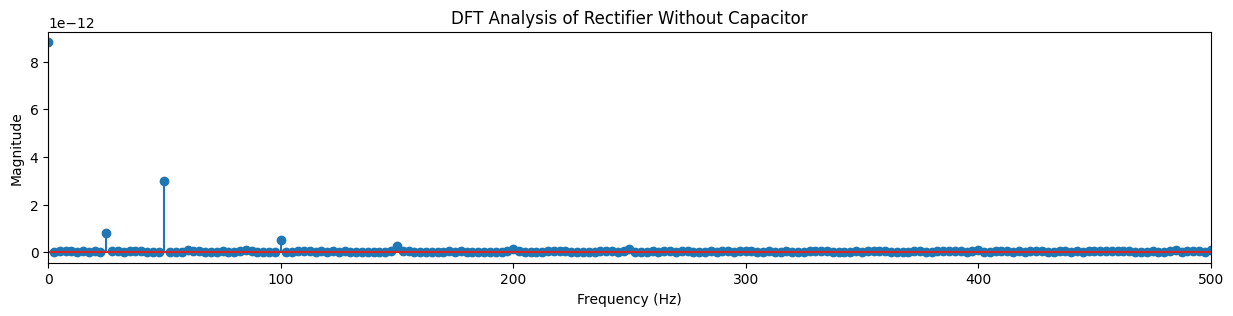

THD: 35.39%


In [93]:
# Rectifier Without Capacitor

plt.figure(figsize=(15, 3))

timestep = 1 / sampling_frequency
freq = np.fft.fftfreq(rectifier_without_cap_current[:sampling_frequency // 10].shape[0], d=timestep) / 4
DFT = np.abs(np.fft.fft(rectifier_without_cap_current[:sampling_frequency // 10]))

plt.stem(freq, DFT)
plt.xlim(0, 500)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('DFT Analysis of Rectifier Without Capacitor')
print(f'Top Frequencies present: {freq[np.argsort(DFT[:len(DFT) // 2])[::-1]][:4]}Hz')
plt.show()

fundamental_freq = 50  # Fundamental frequency in Hz
thd = compute_thd(freq, DFT, fundamental_freq)
print(f"THD: {thd:.2f}%")

Top Frequencies present: [ 50.   0. 100. 150.]Hz


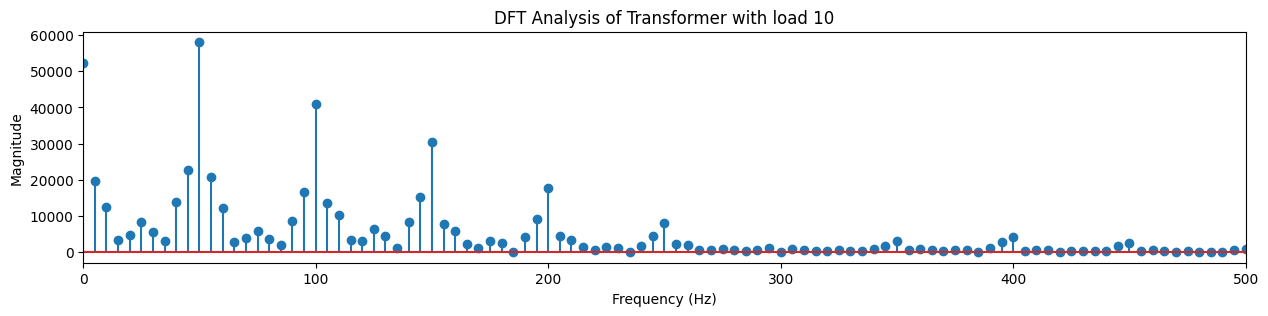

THD: 23.71%


In [94]:
# Transformer With Load 10

plt.figure(figsize=(15, 3))

timestep = 1 / sampling_frequency
freq = np.fft.fftfreq(transformer_with_load_10_current[:sampling_frequency // 10].shape[0], d=timestep)/2
DFT = np.abs(np.fft.fft(transformer_with_load_10_current[:sampling_frequency // 10]))

plt.stem(freq, DFT)
plt.xlim(0, 500)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('DFT Analysis of Transformer with load 10')
print(f'Top Frequencies present: {freq[np.argsort(DFT[:len(DFT) // 2])[::-1]][:4]}Hz')
plt.show()

fundamental_freq = 50  # Fundamental frequency in Hz
# Assuming fft_freq and fft_mag are the arrays containing FFT frequencies and magnitudes
thd = compute_thd(freq, DFT, fundamental_freq)
print(f"THD: {thd:.2f}%")

### **Frequency Estimation**

In [86]:
estimated_freq_rectifier_without_cap, time_stamps = estimate_frequency_trend(rectifier_without_cap_m1_voltage, sampling_rate=200000, window_size=2000, window_func=None)

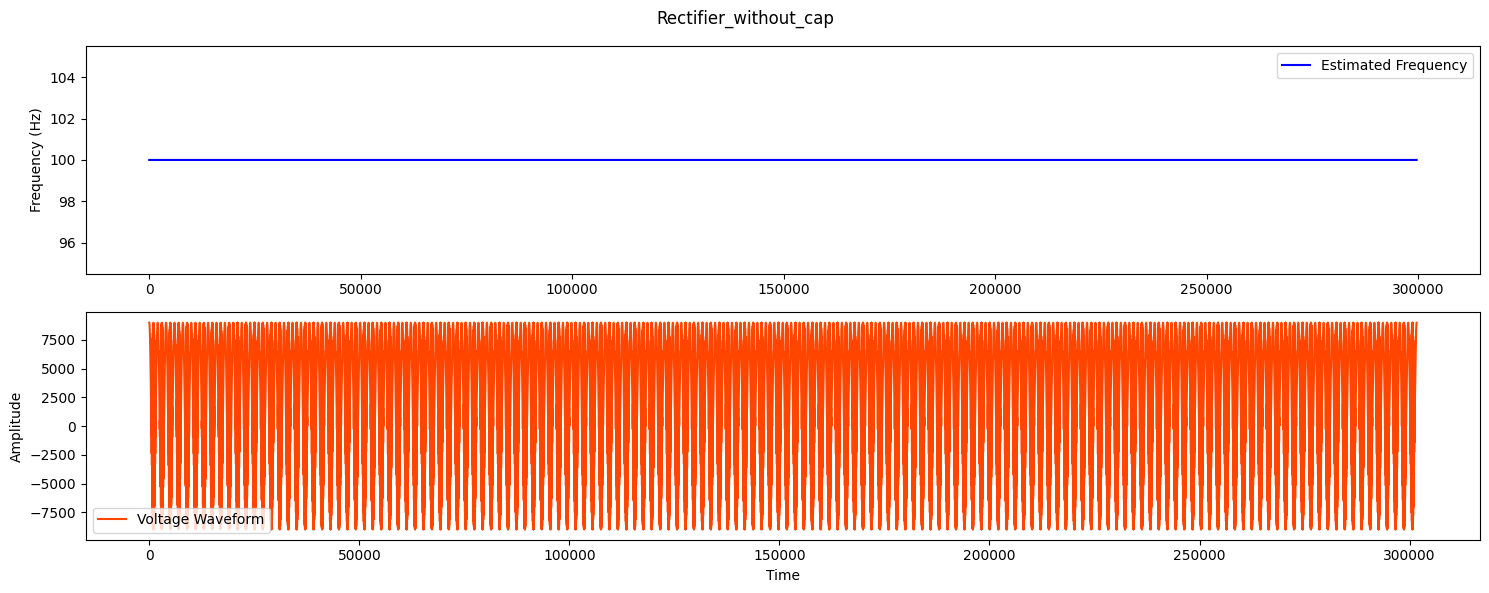

In [87]:
plot_signals('Rectifier_without_cap', estimated_freq_rectifier_without_cap, voltage_waveform = rectifier_without_cap_m1_voltage)

In [90]:
estimated_freq_transformer_with_load_10_voltage, time_stamps = estimate_frequency_trend(transformer_with_load_10_m1_voltage, sampling_rate=200000, window_size=2000, window_func=None)

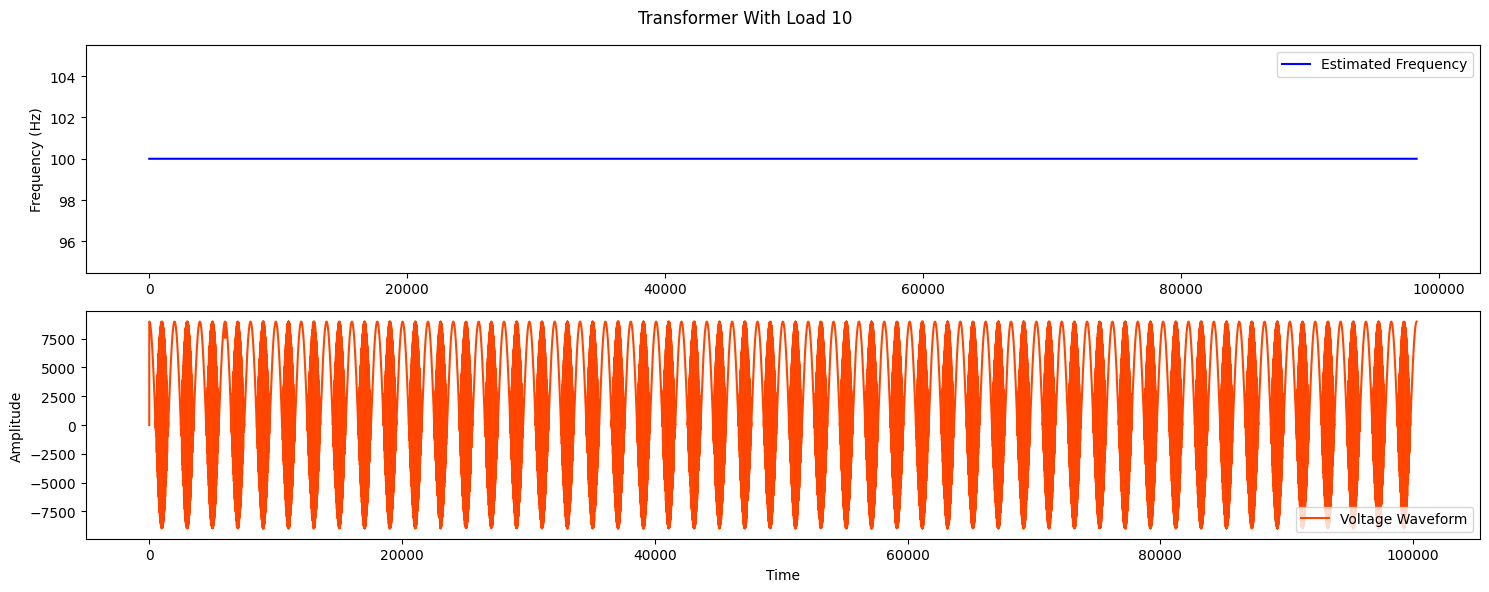

In [91]:
plot_signals('Transformer With Load 10', estimated_freq_transformer_with_load_10_voltage, voltage_waveform = transformer_with_load_10_m1_voltage)